# Medical Image Classification

**Company Use Case:**

**Approach:**

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by MedMNIST v2, a comprehensive collection of standardized biomedical images. It encompasses 12 datasets for 2D and 6 for 3D images, pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with corresponding classification labels. With 708,069 2D images and 9,998 3D images, it supports various classification tasks, from binary/multi-class to ordinal regression and multi-label, catering to biomedical image analysis, computer vision, and machine learning research and education.

https://medmnist.com/

**Dataset  1:**

_OCTMNIST_

MedMNIST Description:

The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/octmnist.npz?download=1

**Dataset 2:**

_PneumoniaMNIST_

MedMNIST Description:

The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/pneumoniamnist.npz?download=1

**Dataset 2:**

<span style="color:red">_NAME_</span> (Maybe BloodMNIST)

MedMNIST Description:

<span style="color:red">TEXT</span>

# FHE Mode

In [1]:
mode = 'simulate'

# mode = 'execute'

# Imports

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

# MedMNIST
import medmnist

# SciKit-Learn
from sklearn.metrics import *

# XGBoost
from xgboost.sklearn import XGBClassifier

# PyTorch
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchsummary import summary

# ConcreteML
from concrete.ml.sklearn import NeuralNetClassifier

In [3]:
# set random seed
np.random.seed(1)
torch.manual_seed(1)

# General Functions

In [4]:
###############################################################
# Logging (KICK AFTER BEING DONE)
###############################################################

def log_parameters(dataset, epochs, learning_rate, weight_decay, model, train_losses, train_accuracies, val_losses, val_accuracies):
    if os.path.isfile(f'{dataset}_Experiments.csv'):
        df = pd.read_csv(f'{dataset}_Experiments.csv')
        df = df.drop_duplicates()
        # append new row
        df = pd.concat([df, pd.DataFrame({
            'epochs': [epochs],
            'learning_rate': [learning_rate],
            'weight_decay': [weight_decay],
            'model': [str(model)],
            'final_train_loss': [train_losses[-1]],
            'final_train_accuracy': [train_accuracies[-1]],
            'final_val_loss': [val_losses[-1]],
            'final_val_accuracy': [val_accuracies[-1]]
            })])
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)

    else:
        df = pd.DataFrame({
        'epochs': [epochs],
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'model': [str(model)],
        'final_train_loss': [train_losses[-1]],
        'final_train_accuracy': [train_accuracies[-1]],
        'final_val_loss': [val_losses[-1]],
        'final_val_accuracy': [val_accuracies[-1]]
        })
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)
    
    return 'Parameters Logged!'

###############################################################
# Load Data
###############################################################

def load_data(dataset):

    '''
    Load data from MedMNIST

    Input:
        dataset (str): name of dataset

    Output:
        X_grayscale (tuple): (xtrain, xval, xtest) grayscale images
        X_rgb (tuple): (xtrain, xval, xtest) rgb images
        y (tuple): (ytrain, yval, ytest) labels
    '''

    # initialize DataClass
    DataClass = getattr(medmnist, dataset)
    # download data
    train_dataset = DataClass(split='train',download=True)
    eval_dataset = DataClass(split='val', download=True)
    test_dataset = DataClass(split='test', download=True)
    # to numpy array
    xtrain, ytrain = train_dataset.imgs, train_dataset.labels
    xval, yval = eval_dataset.imgs, eval_dataset.labels
    xtest, ytest = test_dataset.imgs, test_dataset.labels
    # expand dimension (grayscale)
    # (channels=1, height=28, width=28)
    xtrain_gray = np.expand_dims(xtrain, axis=1)
    xval_gray = np.expand_dims(xval, axis=1)
    xtest_gray = np.expand_dims(xtest, axis=1)
    # expand dimension (rgb) - needed for pretrained models
    # (channels=3, height=28, width=28)
    xtrain_rgb = np.repeat(xtrain_gray, 3, axis=1)
    xval_rgb = np.repeat(xval_gray, 3, axis=1)
    xtest_rgb = np.repeat(xtest_gray, 3, axis=1)

    X_grayscale = (xtrain_gray, xval_gray, xtest_gray)
    X_rgb = (xtrain_rgb, xval_rgb, xtest_rgb)
    y = (ytrain, yval, ytest)

    clear_output()

    return X_grayscale, X_rgb, y

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    accuracy = round(accuracy_score(y_true, y_pred),2)
    precision = round(precision_score(y_true, y_pred),2)
    recall = round(recall_score(y_true, y_pred),2)
    f1 = round(f1_score(y_true, y_pred),2)
    roc_auc = round(roc_auc_score(y_true, y_pred), 2)

    # barchart of metrics for each classifier
    ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc'], [accuracy, precision, recall, f1, roc_auc])
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [5]:
dataset = 'PneumoniaMNIST'

In [6]:
data = load_data(dataset=dataset)

# grayscale images (channels=1)
xtrain_gray, xval_gray, xtest_gray = data[0]
# rgb images (channels=3)
xtrain_rgb, xval_rgb, xtest_rgb = data[1]
# labels
ytrain, yval, ytest = data[2]

In [7]:
print(f'Grayscale Shape: {xtrain_gray.shape}')
print(f'RGB Shape: {xtrain_rgb.shape}')

Grayscale Shape: (4708, 1, 28, 28)
RGB Shape: (4708, 3, 28, 28)


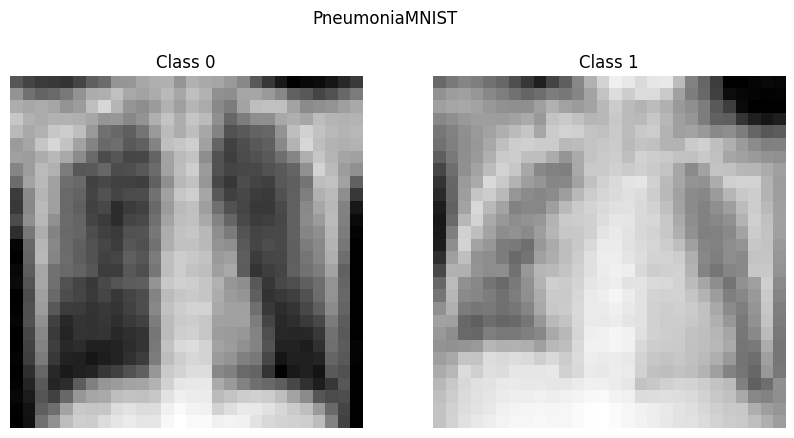

In [8]:
# plot sample images of each class
n_classes = len(np.unique(ytrain))

fig, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(10, 5))
for i in range(n_classes):
    ax[i].imshow(xtrain_gray[ytrain.flatten()==i][0][0], cmap='gray')
    ax[i].set_title(f'Class {i}')
    ax[i].axis('off')
fig.suptitle(dataset)
plt.show()

# Preprocessing

In [9]:
# normalize grayscale images for generic CNN
xtrain_gray= xtrain_gray / 255
xval_gray = xval_gray / 255
xtest_gray = xtest_gray / 255

# Modelling

## Approach 1: Convolutional Neural Network

### PyTorch

In [10]:
class TorchCNN():
    def __init__(self, model):
        self.model = model
        self.log = {
            'train': 0,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, x_train, y_train, x_val, y_val, epochs=30, learning_rate=0.0001, weight_decay=0.0001, plot=True):
        # get number of classes
        n_classes = len(np.unique(y_train))
        # data to tensor
        x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float)
        x_val, y_val = torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float)
        # criterion
        criterion = torch.nn.BCELoss() if n_classes==2 else torch.nn.CrossEntropyLoss()
        # optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # train loop
        train_l, val_l, train_score, val_score= [], [], [], []
        for epoch in tqdm(range(epochs)):

            # set model to train mode
            self.model.train()
            start_time = time.time()
            for i in range(0, len(x_train), 1):
                inputs, labels = x_train[i:i+1], y_train[i:i+1]
                # forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
            epoch_time = time.time() - start_time
            self.log['train'] += epoch_time

            # set model to eval mode
            self.model.eval()
            # calculate curve metrics
            with torch.no_grad():
                train_outputs = self.model(x_train)
                train_loss = criterion(train_outputs, y_train)
                predicted = torch.round(train_outputs)
                train_accuracy = accuracy_score(predicted.detach().numpy(), y_train.detach().numpy())*100

                val_outputs = self.model(x_val)
                val_loss = criterion(val_outputs, y_val)
                predicted = torch.round(val_outputs)
                val_accuracy = accuracy_score(predicted.detach().numpy(), y_val.detach().numpy())*100

            train_l.append(train_loss.item())
            val_l.append(val_loss.item())
            train_score.append(train_accuracy)
            val_score.append(val_accuracy)

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        return self

    def evaluate(self, X):
        # data to tensor
        X = torch.tensor(X, dtype=torch.float)
        # set model to eval mode
        self.model.eval()
        # predict
        start_time = time.time()
        with torch.no_grad():
            # predict each sample individually
            outputs = [self.model(X[[i]]) for i in tqdm(range(X.shape[0]))]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # get binary predictions
        y_pred = torch.round(torch.cat(outputs)).detach().numpy().flatten()

        return y_pred

In [11]:
torch_model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=169, out_features=1, bias=True),
        torch.nn.Sigmoid()
    )

summary(torch_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              10
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
           Flatten-4                  [-1, 169]               0
            Linear-5                    [-1, 1]             170
           Sigmoid-6                    [-1, 1]               0
Total params: 180
Trainable params: 180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


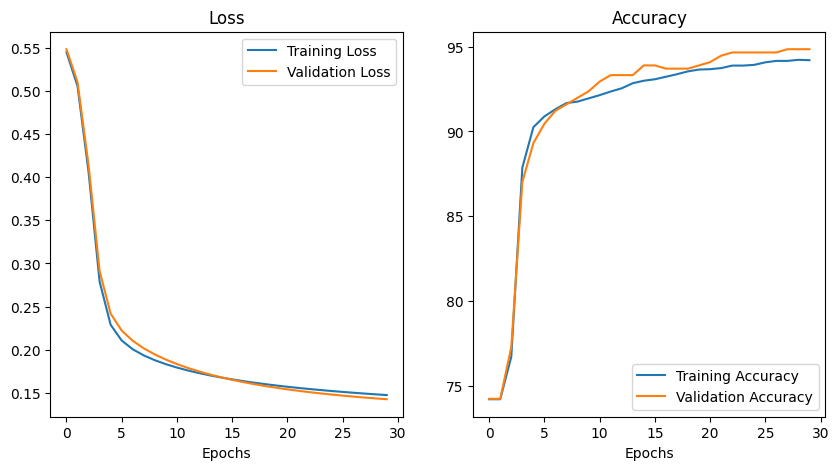

100%|██████████| 624/624 [00:00<00:00, 11320.90it/s]


In [12]:
torch_cnn = TorchCNN(model=torch_model)
torch_cnn = torch_cnn.train(xtrain_gray, ytrain, xval_gray, yval, epochs=30, learning_rate=0.0001, weight_decay=0.0001, plot=True)
ypred_torch = torch_cnn.evaluate(xtest_gray)

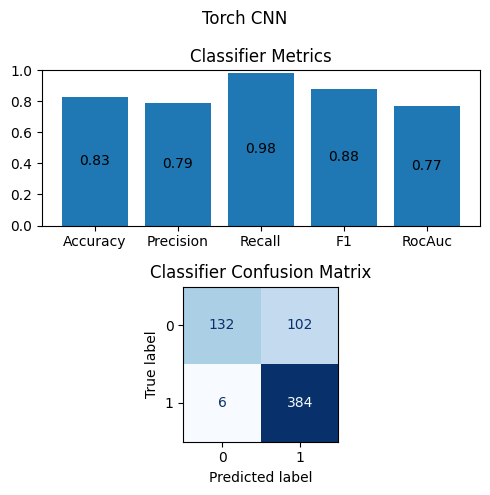

In [13]:
plot_classification_metrics(ytest, ypred_torch, plot_title='Torch CNN')

In [14]:
experiments = pd.read_csv(f'{dataset}_Experiments.csv').sort_values(by='final_val_accuracy', ascending=False)
experiments

,epochs,learning_rate,weight_decay,model,final_train_loss,final_train_accuracy,final_val_loss,final_val_accuracy
0,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.098308,96.197961,0.096934,95.992366
4,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 1, kernel_size=(...",0.108142,96.070518,0.127290,95.419847
2,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 1, kernel_size=(...",0.104789,96.240442,0.123349,95.229008
9,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.108900,95.921835,0.114393,95.229008
8,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.114461,95.433305,0.111210,95.038168
3,20,0.0001,0.0010,"Sequential(\n (0): Conv2d(1, 1, kernel_size=(...",0.098492,96.389125,0.122830,94.847328
1,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.097702,96.091759,0.126715,94.656489
11,50,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.152032,93.776551,0.139573,94.656489
12,100,0.0001,0.0002,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.131718,95.008496,0.117890,94.656489
5,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 1, kernel_size=(...",0.088938,98.237043,0.224892,93.893130


In [15]:
# print top model architecture
print(experiments['model'].iloc[2])

Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=144, out_features=1, bias=True)
  (5): Sigmoid()
)


### Concrete

In [16]:
# class ConcreteCNN():
#     def __init__(self, model):
#         self.model = model
#         self.log = {
#             'train': 0,
#             'evaluate_total': None,
#             'evaluate_sample': None
#         }

#     ##############################################
#     # curve metrics must be calculated without FHE
#     ##############################################

## Approach 2: Feature Extractor (Transfer Learning) & XGBoost

In [17]:
# # check how image looks like after resnet50 preprocessing
# x = train_dataset[0][0][0]
# plt.imshow(x, cmap='gray')
# plt.show()

# # resnet50 preprocessing
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # resnet50 preprocessing
# x = preprocess(x)
# plt.imshow(x[0], cmap='gray')
# plt.show()

## Approach 3: Transfer Learning (Fine-Tuning Layers Encrypted)